# TAREA NO. 3 - ESTADÍSTICA MULTIVARIADA: REGRESIÓN MULTIVARIADA

## 1. Contexto de la base de datos
Este conjutno de datos contiene seis meses de datos de consumo eléctrico de un hogar, recogidos entre enero y junio de 2007. Los datos incluyen información sobre potencia activa global, potencia reactiva global, tensión, intensidad global, submedición 1 (cocina), submedición 2 (lavadero) y submedición 3 (calentador de agua eléctrico y aire acondicionado). Con 260.640 mediciones en total, el objetivo es predecir o estimar el consumo eléctrico de los hogares.

| Nombre de la columna | Descripción |
| --- | --- |
| Fecha | La fecha de la observación. (Fecha) |
| Hora | La hora de la observación. (Hora) |
| Potencia_activa_global | La potencia activa total consumida por el hogar (kilovatios). (Numérico) |
| Potencia_reactiva_global | La potencia reactiva total consumida por el hogar (kilovatios). (Numérico) |
| Voltaje | El voltaje al cual se entrega la electricidad al hogar (voltios). (Numérico) |
| Intensidad_global | La intensidad de corriente promedio entregada al hogar (amperios). (Numérico) |
| Sub_medición_1 | La potencia activa consumida por la cocina (kilovatios). (Numérico) |
| Sub_medición_2 | La potencia activa consumida por la lavandería (kilovatios). (Numérico) |
| Sub_medición_3 | La potencia activa consumida por el calentador de agua eléctrico y el aire acondicionado (kilovatios). (Numérico) |

La variable respuesta para el modelo de regresión múltiple es la potencia aparente global en la red. A priori, esta variable no está incluida dentro del conjunto de datos, por lo que es necesario obtenerla a parir de la potencia reactiva y activa global que si están disponibles en el conjunto de datos.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

### 1.1. Pre-procesamiento de loa datos

In [27]:
def date_to_semester_fraction(date):
    """ Se convierte la fecha a un valor entre 0 y 1 que representa el semestre en el que se encuentra la fecha

    Args:
        date (str): Fecha en formato 'dd/mm/yyyy'

    Returns:
        float: Fracción del semestre en el que se encuentra
    """
    day, month, year = map(int, date.split('/'))
    days_in_month = [31, 28, 31, 30, 31, 30]
    day_of_year = sum(days_in_month[:month - 1]) + day
    return day_of_year / 182

In [28]:
df = pd.read_csv('household_power_consumption.csv')
df = df.replace('?', np.nan)
df = df.dropna()
df['day_frac'] = df['Time'].apply(lambda x: (int(x.split(':')[0]) * 3600 + int(x.split(':')[1]) * 60 + int(x.split(':')[2])) / 86400)
df['semester_frac'] = df['Date'].apply(date_to_semester_fraction)
df = df.drop(['index', 'Date', 'Time'], axis=1)

In [29]:
# Conversión de los datos a float
for col in df.columns:
    df[col] = df[col].astype(np.float32)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256869 entries, 0 to 260639
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    256869 non-null  float32
 1   Global_reactive_power  256869 non-null  float32
 2   Voltage                256869 non-null  float32
 3   Global_intensity       256869 non-null  float32
 4   Sub_metering_1         256869 non-null  float32
 5   Sub_metering_2         256869 non-null  float32
 6   Sub_metering_3         256869 non-null  float32
 7   day_frac               256869 non-null  float32
 8   semester_frac          256869 non-null  float32
dtypes: float32(9)
memory usage: 10.8 MB


##### En este caso, al no tratarse de un modelo pensado para series de tiempo (lo cual sería ideal para este tipo de bases de datos ya que los datos presentan patrones estacionales), se optó por convertir las variables de fecha y tiempo en variables numéricas de la siguiente forma: i) para la fecha, se consideró el tiempo de desde enero de 2007 hasta junio de 2007, que es un semestre, como el 100% del tiempo, por lo que la columna de feca ahora es un valor entre 0.0 y 1.0 que representa el porcentaje del semestre que ha transcurrido; ii) el tiempo tiene un análisis similar, pero ahora se considera es el porcentaje del día que ha transcurrido, esto debido a que la base de datos esta compuesta por muestras tomadas en cada minuto el día durante los 6 meses.

In [30]:
# Se calcula la potencia aparente global a partir de la potencia activa y reactiva usando la fórmula S = sqrt(P^2 + Q^2)
df['Global_apparent_power'] = np.sqrt(df['Global_active_power'] ** 2 + df['Global_reactive_power'] ** 2)
df.drop(['Global_active_power', 'Global_reactive_power'], axis=1, inplace=True)

##### La potencia aparente se calcula a partir de la potencia reactiva y activa como la raíz de la suma de estas componentes al cuadrado como se muestra en la imagen:

In [31]:
from IPython.display import Image
Image(url= "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEic9D1dQVBXgZ-fxxRSRj-_P7lt_BmaEN7pMRtQ61d2tJFni3JTcGlwf1HZdggjAozWL6xHH5HpbXPVTXRrngbO7nxhLOsTUlP9r4NUznCOOy278Ufg96I4LzMMSfgxHs4DuIoR7HUnKpI6/s1600/triangulo.png", width=400, height=300)

In [32]:
df.head()

,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day_frac,semester_frac,Global_apparent_power
0,241.970001,10.6,0.0,0.0,0.0,0.000000,0.005495,2.583582
1,241.750000,10.4,0.0,0.0,0.0,0.000694,0.005495,2.553959
2,241.639999,10.4,0.0,0.0,0.0,0.001389,0.005495,2.551960
3,241.710007,10.4,0.0,0.0,0.0,0.002083,0.005495,2.551960
4,241.979996,10.4,0.0,0.0,0.0,0.002778,0.005495,2.555957


### 1.2. Obtención de los valores X e y para entrenar al modelo de regresión

In [33]:
y = df['Global_apparent_power'].to_numpy()
X = df.drop('Global_apparent_power', axis=1).to_numpy()

print('Las dimensiones de X son:', X.shape, 'y las dimensiones de y son:', y.shape)

Las dimensiones de X son: (256869, 7) y las dimensiones de y son: (256869,)


##### Finalmente, el conjunto de datos es un conjunto de 256.869 observaciones con 7 variables predictoras y una sola variable respuesta que estima el consumo en una casa a partir de las mediciones hechas en diferentes áreas de la casa.

##### El reto en este caso es estimar ese consumo considerando que hay algunas mediciones no tomadas en cuenta, como, por ejemplo, algunas cargas inductivas o capacitivas que producen una componente reactiva de la potencia y que no se ve reflejada en los medidores (ya que estos solo miden potencia activa). Además, podría haber otros medidores que no fueron tenidos en cuenta o habitaciones que no fueron monitoreadas.

## 2. Creación y comparación del Modelo de Regresión Multiple Lineal

### 2.1 Proceso de validacion cruzada

- alpha: Este parámetro es utilizado como un coeficiente de regularización en algoritmos como la regresión Ridge o Lasso. La regularización ayuda a prevenir el sobreajuste añadiendo una penalización a la complejidad del modelo. Valores más altos de alpha incrementan la penalización, lo que puede simplificar el modelo pero también puede llevar a un subajuste si es demasiado alto.

- max_iter: Este parámetro especifica el número máximo de iteraciones que debe ejecutar el algoritmo. Es crucial para algoritmos iterativos como el descenso de gradiente, donde los parámetros del modelo se actualizan repetidamente para minimizar la función de pérdida. Un número insuficiente de iteraciones puede resultar en una convergencia incompleta, mientras que demasiadas iteraciones pueden aumentar el tiempo de cómputo sin beneficios adicionales significativos.

- tol: Abreviatura de tolerancia, este parámetro determina el umbral para el criterio de parada. Si el cambio en la función de pérdida entre iteraciones es menor que tol, el algoritmo se detendrá prematuramente, asumiendo que ha convergido a una solución óptima. Un valor de tol demasiado alto puede llevar a una convergencia prematura, mientras que un valor demasiado bajo puede resultar en un tiempo de cómputo innecesariamente largo.

In [34]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [35]:
# Se realiza una validación cruzada para encontrar los mejores hiperparámetros
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = pd.DataFrame(columns=['alpha', 'max_iter', 'tol', 'mae', 'n_zeros'])
kf_scores_transf = pd.DataFrame(columns=['alpha', 'max_iter', 'tol', 'mae', 'n_zeros'])

# Proceso e validación cruzada con diferentes hiperparámetros (alpha, max_iter, tol)
for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    for max_iter in [100, 500, 1000]:
        for tol in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
            scores = []
            scores_transf = []
            for train_index, val_index in kf.split(X):
                # Dividir los datos en entrenamiento y prueba
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                
                scaler = StandardScaler().fit(X_train)
                X_train_transf = scaler.transform(X_train)
                X_val_transf = scaler.transform(X_val)
                
                max, min = np.max(y_train), np.min(y_train)
                y_train_transf = (y_train - min) / (max - min)
                
                # Definir el modelo Lasso
                model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol)
                model_transf = Lasso(alpha=alpha, max_iter=max_iter, tol=tol)
                
                # Entrenar el modelo
                model.fit(X_train, y_train)
                model_transf.fit(X_train_transf, y_train_transf)
                
                # Realizar predicciones
                preds = model.predict(X_val)
                preds_transf = model_transf.predict(X_val_transf)
                
                # Calcular el error medio absoluto
                mae = mean_squared_error(y_val, preds)
                scores.append(mae)
                
                mae_transf = mean_squared_error(y_val, preds_transf * (max - min) + min)
                scores_transf.append(mae_transf)
                
                # Contar el número de coeficientes iguales a cero para evaluar la regularización
                n_zeros = np.sum(model.coef_ == 0)
                n_zeros_transf = np.sum(model_transf.coef_ == 0)
                
            # Guardar los resultados de la validación cruzada para análisis posterior
            kf_scores.loc[len(kf_scores)] = [alpha, max_iter, tol, np.mean(scores), n_zeros]
            kf_scores_transf.loc[len(kf_scores_transf)] = [alpha, max_iter, tol, np.mean(scores_transf), n_zeros]

kf_scores['n_zeros'] = kf_scores['n_zeros'].astype(int)
kf_scores['max_iter'] = kf_scores['max_iter'].astype(int)

kf_scores_transf['n_zeros'] = kf_scores_transf['n_zeros'].astype(int)
kf_scores_transf['max_iter'] = kf_scores_transf['max_iter'].astype(int)

### 2.2. Elección del mejor modelo (en terminos del error) vs. el modelo con la menor cantidad de preictores

In [36]:
results = kf_scores.sort_values('mae').reset_index(drop=True)
results.head()

,alpha,max_iter,tol,mae,n_zeros
0,0.0001,100,0.0010,0.001921,0
1,0.0001,500,0.0010,0.001921,0
2,0.0001,1000,0.0010,0.001921,0
3,0.0001,1000,0.0001,0.001921,0
4,0.0001,100,0.0001,0.001921,0


In [37]:
results_transf = kf_scores_transf.sort_values('mae').reset_index(drop=True)
results_transf.head()

,alpha,max_iter,tol,mae,n_zeros
0,0.0001,100,0.00001,0.001933,0
1,0.0001,500,0.00001,0.001933,0
2,0.0001,1000,0.00001,0.001933,0
3,0.0001,1000,0.00010,0.001934,0
4,0.0001,100,0.00010,0.001934,0


In [38]:
print('Hay un total de', np.unique(results['n_zeros']), 'valores diferentes de coeficientes iguales a cero cuando no se aplica la transformación de los datos')
print('Hay un total de', np.unique(results_transf['n_zeros']), 'valores diferentes de coeficientes iguales a cero cuando se aplica la transformación de los datos')

Hay un total de [0 2 4 5 7] valores diferentes de coeficientes iguales a cero cuando no se aplica la transformación de los datos
Hay un total de [0 2 4 5 7] valores diferentes de coeficientes iguales a cero cuando se aplica la transformación de los datos


##### Los resultados obtenidos muestran que, tras probar el modelo con diferentes parámetros, es posible que en algunos casos se usen todos los predictores, solo se usen algunos o no se use ninguno de ellos y solo se tenga en cuenta el intercepto. Para saber cual es el mejor modelo se hace un análisis del error absoluto medio en relación con la cantidad de predictores iguales a cero.

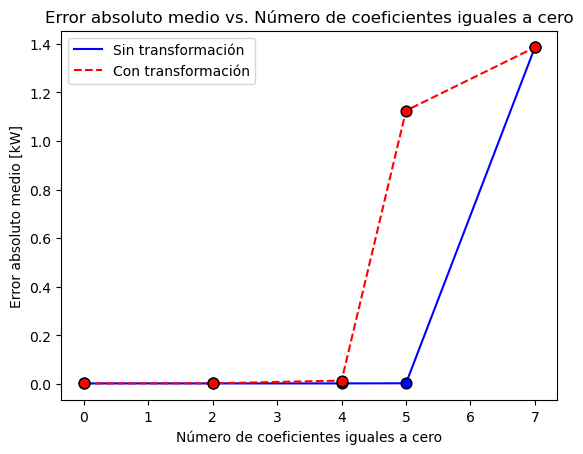

In [39]:
error = []
error_transf = []
for i in np.unique(results['n_zeros']):
    error.append(results[results['n_zeros'] == i].iloc[0]['mae'])
    error_transf.append(results_transf[results_transf['n_zeros'] == i].iloc[0]['mae'])

plt.scatter(np.unique(results['n_zeros']), error, s=60, c='b', edgecolors='k', zorder=3, clip_on=False)
plt.plot(np.unique(results['n_zeros']), error, c='b', zorder=2, linestyle='-', label='Sin transformación')

plt.scatter(np.unique(results_transf['n_zeros']), error_transf, s=60, c='r', edgecolors='k', zorder=3, clip_on=False)
plt.plot(np.unique(results_transf['n_zeros']), error_transf, c='r', zorder=2, linestyle='--', label='Con transformación')

plt.xlabel('Número de coeficientes iguales a cero')
plt.ylabel('Error absoluto medio [kW]')
plt.title('Error absoluto medio vs. Número de coeficientes iguales a cero')
plt.legend()
plt.show()

Resultados para datos sin transformación:

In [40]:
best_n = -1
E = []
alpha = (results['mae'].max() / len(results)) / np.max(np.unique(results['n_zeros']))

for i, j in zip(np.unique(results['n_zeros']), error):
    print(f'El error medio absoluto para {i} predictores iguales a cero es: {j:.4f} kW')
    metric = j + (X.shape[1] - i) * alpha
    E.append(metric)
    if E[-1] == np.min(E):
        best_n = i
        
print(f'\nEl mejor modelo es aquel con {best_n} predictores iguales a cero')

El error medio absoluto para 0 predictores iguales a cero es: 0.0019 kW
El error medio absoluto para 2 predictores iguales a cero es: 0.0019 kW
El error medio absoluto para 4 predictores iguales a cero es: 0.0020 kW
El error medio absoluto para 5 predictores iguales a cero es: 0.0025 kW
El error medio absoluto para 7 predictores iguales a cero es: 1.3853 kW

El mejor modelo es aquel con 5 predictores iguales a cero


Resultados para datos con transformación:

In [41]:
best_n_transf = -1
E_transf = []
alpha_transf = (results_transf['mae'].max() / len(results_transf)) / np.max(np.unique(results_transf['n_zeros']))

for i, j in zip(np.unique(results_transf['n_zeros']), error_transf):
    print(f'El error medio absoluto para {i} predictores iguales a cero es: {j:.4f} kW')
    metric = j + (X.shape[1] - i) * alpha_transf
    E_transf.append(metric)
    if E_transf[-1] == np.min(E_transf):
        best_n_transf = i
        
print(f'\nEl mejor modelo es aquel con {best_n_transf} predictores iguales a cero')

El error medio absoluto para 0 predictores iguales a cero es: 0.0019 kW
El error medio absoluto para 2 predictores iguales a cero es: 0.0023 kW
El error medio absoluto para 4 predictores iguales a cero es: 0.0135 kW
El error medio absoluto para 5 predictores iguales a cero es: 1.1251 kW
El error medio absoluto para 7 predictores iguales a cero es: 1.3853 kW

El mejor modelo es aquel con 2 predictores iguales a cero


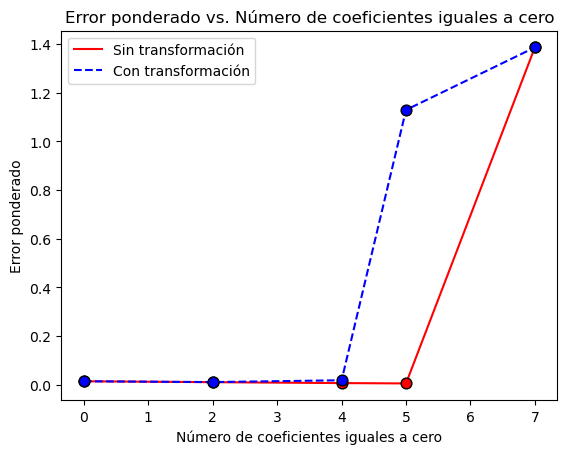

In [42]:
plt.scatter(np.unique(results['n_zeros']), E, s=60, c='r', edgecolors='k', zorder=3, clip_on=False)
plt.plot(np.unique(results['n_zeros']), E, c='r', zorder=2, linestyle='-', label='Sin transformación')

plt.scatter(np.unique(results_transf['n_zeros']), E_transf, s=60, c='b', edgecolors='k', zorder=3, clip_on=False)
plt.plot(np.unique(results_transf['n_zeros']), E_transf, c='b', zorder=2, linestyle='--', label='Con transformación')

plt.xlabel('Número de coeficientes iguales a cero')
plt.ylabel('Error ponderado')
plt.title('Error ponderado vs. Número de coeficientes iguales a cero')
plt.legend()
plt.show()

##### El modelo de regresión múltiple lineal que tiene mejor desempeño en relación con la menor cantidad de predictores se obtiene usando la siguiente métrica: El máximo error obtenido durante todos los entrenamientos se divide entre el numero total de entrenamientos. Este valor a su vez se divide entre el número máximo de predictores con un factor de 0.0. Este resultado se denomina Alpha. Con este valor, se calcula la suma entre el mejor error obtenido con x cantidad de predictores en cero, y la multiplicación entre el número de predictores diferentes de cero y Alpha. Esta métrica da como resultado el mejor modelo en relación error/número de predictores diferentes de cero.

##### El mejor modelo en este caso es el siguiente, tanto para los datos transformados como no transformados con el escalador estandar:

In [43]:
print('Modelo para datos sin transformar:')
best_model = results[results['n_zeros'] == best_n].iloc[0]
best_model = {
    'alpha': best_model['alpha'],
    'max_iter': int(best_model['max_iter']),
    'tol': best_model['tol']
}
best_model

Modelo para datos sin transformar:


{'alpha': 0.1, 'max_iter': 500, 'tol': 0.1}

In [44]:
print('Modelo para datos transformados:')
best_model_transf = results_transf[results_transf['n_zeros'] == best_n_transf].iloc[0]
best_model_transf = {
    'alpha': best_model_transf['alpha'],
    'max_iter': int(best_model_transf['max_iter']),
    'tol': best_model_transf['tol']
}
best_model_transf

Modelo para datos transformados:


{'alpha': 0.001, 'max_iter': 100, 'tol': 0.0001}

##### Estos resultados muestran que, para este conjunto de datos, no hay un efecto significativo entre transformar los datos o no, ya que los resultados de MAE son los mismos y el modelo también.

## 2.3. Testo de los modelos generados

In [45]:
model = Lasso(**best_model)
model_transf = Lasso(**best_model_transf)

In [46]:
print('Entrenando el modelo sin transformación...')
model.fit(X, y)
preds = model.predict(X_test)
mae = mean_squared_error(y_test, preds)
print(f'Error absoluto medio: {mae:.4f} kW')
print(f'Coeficientes del modelo: {model.coef_}')
print(f'Intercepto del modelo: {model.intercept_}')

Entrenando el modelo sin transformación...
Error absoluto medio: 0.0024 kW
Coeficientes del modelo: [ 0.          0.23006023  0.          0.          0.00149158  0.
 -0.        ]
Intercepto del modelo: 0.02929377555847168


In [47]:
print('Entrenando el modelo con transformación...')

scaler = StandardScaler().fit(X)
X_transf = scaler.transform(X)
X_test_transf = scaler.transform(X_test)

max, min = np.max(y), np.min(y)
y_transf = (y - min) / (max - min)

model_transf.fit(X_transf, y_transf)
preds_transf = model_transf.predict(X_test_transf)
mae_transf = mean_squared_error(y_test, preds_transf * (max - min) + min)
print(f'Error absoluto medio: {mae_transf:.4f} kW')
print(f'Coeficientes del modelo: {model_transf.coef_}')
print(f'Intercepto del modelo: {model_transf.intercept_}')

Entrenando el modelo con transformación...
Error absoluto medio: 0.0022 kW
Coeficientes del modelo: [ 0.0000000e+00  1.0946964e-01  0.0000000e+00  0.0000000e+00
  7.7120453e-04  0.0000000e+00 -3.2813768e-05]
Intercepto del modelo: 0.10381332039833069


##### Las variables con coeficientes distintos de cero son las que Lasso considera estadísticamente significativas. Sin embargo, a continucación se hace el análisis sin usar Lasso para ver si los resultados son consistentes.

##### Los dos modelos, sin transformar los datos y transformando los datos, obtuvieron un error de 2.4 y 2.2 W, respectivamente. Ambos modelos difieren solo en 0.2 W, lo que significa que transformar los datos no afecta significativamente los resultados en un modelo de regresión lineal. Por lo tanto, de aquí en adelante el análisis se hará para el modelo sin los datos transformados por simplicidad. 

In [57]:
def calcular_significancia(model, X, y, transform=False):
    from scipy import stats
    n, p = X.shape
    coef = model.coef_
    y_pred = model.predict(X)
    max, min = np.max(y), np.min(y)
    residuos = y - (y_pred * (max - min) + min) if transform else (y - y_pred)
    rss = np.sum(residuos ** 2)
    stderr = np.sqrt(rss / (n - p - 1)) / np.sqrt(np.sum((X - np.mean(X, axis=0)) ** 2, axis=0))
    t_stats = coef / stderr
    p_values = [2 * (1 - stats.t.cdf(np.abs(i), n - p - 1)) for i in t_stats]
    
    for i, col in enumerate(df.columns[:-1]):
        print(f'{col}: coef={coef[i]:.4f}, t={t_stats[i]:.4f}, p={p_values[i]:.4f}')
        
calcular_significancia(model, X, y)

Voltage: coef=0.0000, t=0.0000, p=1.0000
Global_intensity: coef=0.2301, t=11107.1143, p=0.0000
Sub_metering_1: coef=0.0000, t=0.0000, p=1.0000
Sub_metering_2: coef=0.0000, t=0.0000, p=1.0000
Sub_metering_3: coef=0.0015, t=117.8284, p=0.0000
day_frac: coef=0.0000, t=0.0000, p=1.0000
semester_frac: coef=-0.0000, t=-0.0000, p=1.0000


In [59]:
coefs = model.coef_
coefs_abs = np.abs(coefs)
variables_importancia = sorted(zip(df.columns[:-1], coefs_abs), key=lambda x: x[1], reverse=True)

print('Variables ordenadas por importancia:')
for var, imp in variables_importancia:
    print(f'{var}: {imp:.4f}')

Variables ordenadas por importancia:
Global_intensity: 0.2301
Sub_metering_3: 0.0015
Voltage: 0.0000
Sub_metering_1: 0.0000
Sub_metering_2: 0.0000
day_frac: 0.0000
semester_frac: 0.0000


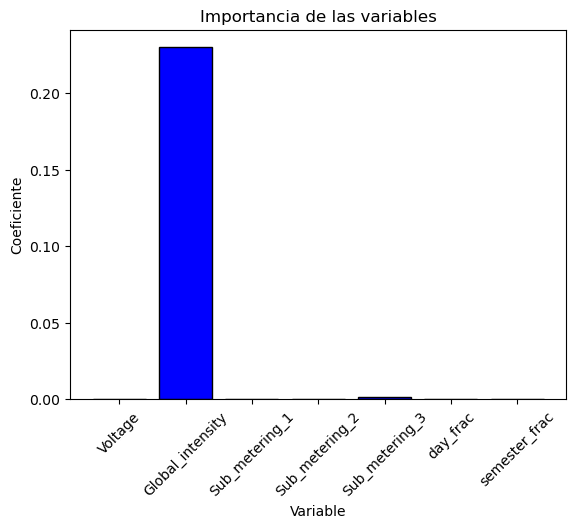

In [60]:
plt.bar(df.columns[:-1], coefs_abs, color='b', edgecolor='k')
plt.xlabel('Variable')
plt.ylabel('Coeficiente')
plt.title('Importancia de las variables')
plt.xticks(rotation=45)
plt.show()

## 3. Validación de los supuestos

In [61]:
residuos = y - model.predict(X)

### Supuesto 1: Normalidad de los Residuos

Estadístico de prueba: 0.4401
P-valor: 0.0000


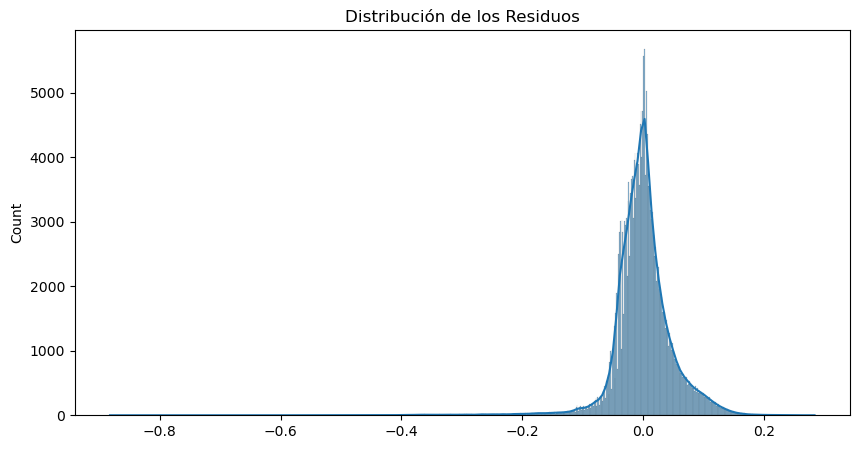

In [63]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Test de Kolmogorov-Smirnov
ks_stat, ks_p_value = stats.kstest(residuos, 'norm')

print(f'Estadístico de prueba: {ks_stat:.4f}')
print(f'P-valor: {ks_p_value:.4f}')

# Histograma de los residuos
plt.figure(figsize=(10, 5))
sns.histplot(residuos, kde=True)
plt.title('Distribución de los Residuos')
plt.show()

##### Según la gráfica y la prueba de Kolmogorov-Smirnov, el valor p es de cero. Deifniendi entonces un nivel de confianza del 95%, se indica que hay evidencia suficiente para rechazar la hipótesis nula, ya que p<0.05, sugiriendo que los residuos no se distribuyen de forma normal, aunque la grafica mostrara que es muy similar a una distribución normal.

### Supuesto 2: Homocedasticidad de los Residuos

La homocedasticidad implica que los residuos tengan una varianza constante a lo largo de los valores de predicción. Para verificarla, se puede hacer un gráfico de los valores predichos contra los residuos:

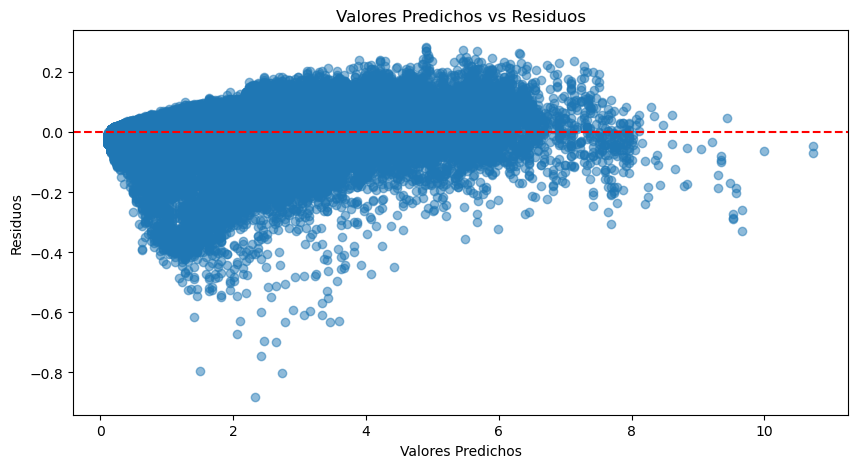

In [65]:
# Gráfico de valores predichos vs residuos
predicciones = model.predict(X)

plt.figure(figsize=(10, 5))
plt.scatter(predicciones, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Valores Predichos vs Residuos')
plt.show()

In [67]:
from scipy.stats import levene

# Realizar el test de Levene
levene_stat, levene_p_value = levene(*[residuos[X[:, i] == val] for i in range(X.shape[1]) for val in np.unique(X[:, i])])

print(f'Estadístico de prueba de Levene: {levene_stat:.4f}')
print(f'P-valor: {levene_p_value:.4f}')


Estadístico de prueba de Levene: 16.7884
P-valor: 0.0000


##### En este caso, usando el test de Levene ya que los residuos no se distribuyen de forma normal, el valor p nuevamente es cero, lo que indica que, con un nivel de confianza del 95%, siendo la hipótesis nula que hay homogeneidad de varianzas, se rechaza entonces la hipótesis nula, por lo que hay heterogeneidad de varianzas.

## Supuesto 3: No Autocorrelación de los Residuos

Un valor cercano a 2 indica poca o ninguna autocorrelación en los residuos en la prueba de Durbin-Watson

- d = 2 indica que no hay autocorrelación
- d <2 indica correlación serial positiva
- d > 2 indica correlación serial negativa

In [69]:
from statsmodels.stats.stattools import durbin_watson

# Test de Durbin-Watson
durbin_watson_test = durbin_watson(residuos)

print(f'Estadístico de prueba de Durbin-Watson: {durbin_watson_test:.2f}')

Estadístico de prueba de Durbin-Watson: 2.00


##### Con el test de Durbin-Watson nos damos cuenta que no hay autocorrelación entre los residuos, ya que el test arroja un valor de 2.

## Supuesto 4: No Multicolinealidad entre las Variables Predictoras

La multicolinealidad se evalúa mediante el Factor de Inflación de la Varianza (VIF). Si alguna variable tiene un VIF alto (usualmente mayor a 5 o 10), sugiere multicolinealidad.

In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns[:-1]
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,Voltage,8.119189
1,Global_intensity,6.783748
2,Sub_metering_1,1.609884
3,Sub_metering_2,1.611338
4,Sub_metering_3,2.746316
5,day_frac,4.390612
6,semester_frac,4.238138


##### Con el test de multicolinealidad de las variables se evidencia que el voltaje tiene un valor alto de colinealidad, esto debido a que las variables de voltaje, corriente y potencia están relacionadas por una formula eléctrica (P=V*I), considerando claro las componentes reactivas y activas de la potencia. Sin embargo, anteriormente se mostró como el modelo Lasso es capaz de identificar que el voltaje no es significativo y esto tiene sentido ya que hay una variable como lo es la corriente, con quien existe una colinealidad, que podría explicarla y no es necesario poner las dos.

##### Algo similar ocurre con las variables de tiempo, que recordemos que en este análisis se convierten a valores en 0 y 1 que representar el porcentaje de cierta estacionalidad. Como hay cierta similitud entre las dos, ya que están relacionadas con un periodo, hay una colinealidad significativa en la prueba. Sin embargo, tanto Lasso como la prueba de significancia estadística de los predictores arrojaron que no son relevantes para el modelo.